In [117]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage, misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle




In [11]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path = root)
    tar.close()

root_dir = '/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN'
maybe_extract(root_dir + '/data/train.tar.gz')
maybe_extract(root_dir + '/data/test.tar.gz')

/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train already present - Skipping extraction of /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train.tar.gz.
Extracting data for /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/test. This may take a while. Please wait.


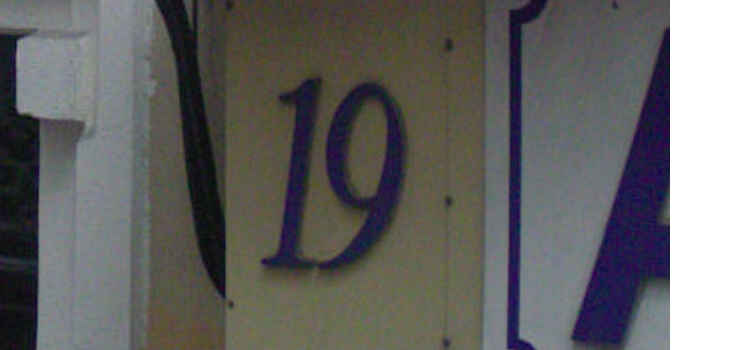

In [184]:
from IPython.display import Image
display(Image(filename= root_dir + '/data/train/1.png'))

TO DO: coverting from .mat to .csv

In [231]:
import csv
def read_csv(filename):
    with open(filename , 'rb') as f:
        reader = csv.reader(f)
        data_list = list(reader)
        
        d = {}
        for item in data_list:
            if not item[1].isdigit():
                continue
            if not item[0] in d:
                d[item[0]] = []
            d[item[0]].append([int(x) for x in item[1:]])
            if item[0].startswith('1.png'):
                print (item[0], item[1:], d[item[0]])
        return d, len(data_list)
                

labels_train_data_dict, training_digits = read_csv(root_dir + '/data/train/trainData.csv')
labels_test_data_dict, test_digits = read_csv(root_dir + '/data/test/testData.csv')
print (len(labels_train_data_dict), training_digits)
print (len(labels_test_data_dict), test_digits)

1.png ['1', '246', '77', '81', '219'] [[1, 246, 77, 81, 219]]
1.png ['9', '323', '81', '96', '219'] [[1, 246, 77, 81, 219], [9, 323, 81, 96, 219]]
1.png ['5', '43', '7', '19', '30'] [[5, 43, 7, 19, 30]]
33402 73258
13068 26033


In [233]:
labels_train_data_dict['1.png']

[[1, 246, 77, 81, 219], [9, 323, 81, 96, 219]]

(350, 741, 3)
[1, 246, 77, 81, 219]
[9, 323, 81, 96, 219]
[1, 9]


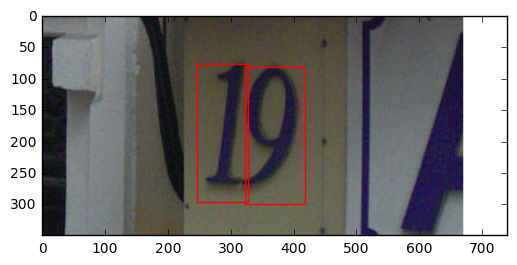

In [234]:
to_display = '1.png'

import matplotlib.patches as patches
from PIL import Image

im = np.array(Image.open(root_dir + '/data/train/' + to_display), dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)
print (im.shape)
for digit_loc in labels_train_data_dict[to_display]:
    # Create a Rectangle patch
    print (digit_loc)
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
print ([d[0] for d in labels_train_data_dict[to_display]])
plt.show()

Resize pictures to 64*128 grayscale and save them into train.pickle and labels into labels_train.pickle.

In [240]:
def rescale(img, l, height, width):
    ph = float(img.shape[0])/height
    pw = float(img.shape[1])/width
    return [l[0], float(l[1])/ph, float(l[2])/pw, float(l[3])/pw, float(l[4])/ph]

image_orig = ndimage.imread(root_dir + '/data/train/1.png' , flatten=True)

print (rescale(image_orig, [1, 246, 77, 81, 219], 64, 128))

[1, 44.98285714285714, 13.300944669365721, 13.991902834008098, 40.04571428571428]


In [241]:
pixel_depth = 255.0
height = 64
width = 128

def save_to_pickle_file(set_filename, folder, labels):
    if os.path.exists(folder + set_filename):
        return
    image_files = os.listdir(root_dir + folder)
    d = dict()
    dataset = np.ndarray(shape=(len(image_files), height, width), dtype=np.float32)
    num_images = 0
    for image in image_files:
        if not image.endswith('.png'):
            continue
        image_file = os.path.join(root_dir + folder, image)
        try:
            image_orig = ndimage.imread(image_file, flatten=True)
            d[num_images] = list()
            for l in labels[image]:
                rescaled = rescale(image_orig, l, height, width)
                d[num_images].append(rescaled)
            image_data = (misc.imresize(image_orig, (height, width)).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (height, width):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    try:
        pickle.dump(dataset, open(root_dir + folder + set_filename, 'wb'), pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
        
    try:
        file_name = "labels_" + set_filename
        pickle.dump(d, open( root_dir + folder + file_name, "wb" ))
    except Exception as e:
        print('Unable to save data to', file_name, ':', e)
        

save_to_pickle_file('train.pickle', '/data/train/', labels_train_data_dict)
# save_to_pickle_file('test.pickle',  '/data/test/', test_data)

11111
[1, 246, 77, 81, 219]
[1, 44.98285714285714, 13.300944669365721, 13.991902834008098, 40.04571428571428]
[9, 323, 81, 96, 219]
[9, 59.06285714285714, 13.991902834008098, 16.582995951417004, 40.04571428571428]


In [242]:
train_data = pickle.load(open(root_dir + '/data/train/train.pickle', 'rb'))
print (train_data.shape)
labels_train_data = pickle.load(open(root_dir + '/data/train/labels_train.pickle', 'rb'))

(11111, 64, 128)


[1, 42.666666666666664, 1.9104477611940298, 9.552238805970148, 52.148148148148145]
[10, 54.51851851851852, 0.0, 17.19402985074627, 52.148148148148145]
[9, 75.85185185185185, 0.0, 19.104477611940297, 52.148148148148145]


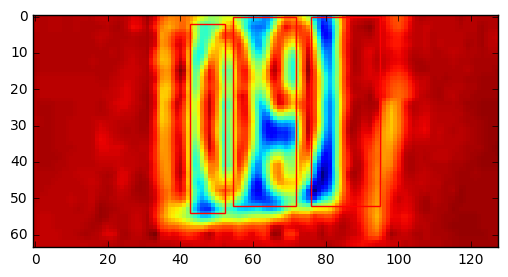

In [248]:
# print (train_data[0]*pixel_depth+pixel_depth/2)
# print (labels_train_data[0])
index = 2
fig,ax = plt.subplots(1)
plt.imshow(train_data[index], interpolation='nearest')
for digit_loc in labels_train_data[index]:
    # Create a Rectangle patch
    print (digit_loc)
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()


In [90]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets(root_dir+'/data/MNIST', one_hot=True)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

## Dropout
keep_prob = tf.placeholder(tf.float32)

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# print (mnist.train.num_examples())

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

for i in range(1000):
    if i%100 == 0:
      batch = mnist.train.next_batch(200)
      train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
      print("step %d, training accuracy %g"%(i, train_accuracy))
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

save_path = saver.save(sess, root_dir + "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)

Extracting /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/MNIST/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.045
step 100, training accuracy 0.91
step 200, training accuracy 0.95
step 300, training accuracy 0.935
step 400, training accuracy 0.935
step 500, training accuracy 0.97
step 600, training accuracy 0.94
step 700, training accuracy 0.97
step 800, training accuracy 0.975
step 900, training accuracy 0.975
test accuracy 0.9748
Model saved in file: /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/tmp/model.ckpt


In [101]:
image_file = os.path.join(root_dir + '/data/train/', '1.png')
xx = ndimage.imread(image_file)
print (xx.shape)

(350, 741, 3)
